In [1]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np

import xarray as xr

import regionmask

import pandas as pd

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import cartopy.feature as cfeat

import glob


import sys
sys.path.append('../')
import grid_model as gridmod

np.seterr(invalid='ignore'); # disable a warning from matplotlib and cartopy

# Import Data

### Load in GEOS Chem Runs

Using egrid, NEI, and our model emissions inventories for NO, NO2, SO2

In [2]:
ds_MODEL_speciesconc = xr.open_mfdataset('../../GCrundirs/type_NA-out_conc-yr_2016-gridmod_final-validation/OutputDir/GEOSChem.SpeciesConc.20150*_0000z.nc4',combine='by_coords')
ds_MODEL_aerosolmass = xr.open_mfdataset('../../GCrundirs/type_NA-out_conc-yr_2016-gridmod_final-validation/OutputDir/GEOSChem.AerosolMass.20150*_0000z.nc4',combine='by_coords')
ds_MODEL = xr.merge([ds_MODEL_aerosolmass, ds_MODEL_speciesconc])
ds_MODEL.attrs['name'] = 'normal'

ds_nonuc_speciesconc = xr.open_mfdataset('../../GCrundirs/type_NA-out_conc-yr_2016-gridmod_nonuclear/OutputDir/GEOSChem.SpeciesConc.20150*_0000z.nc4',combine='by_coords')
ds_nonuc_aerosolmass = xr.open_mfdataset('../../GCrundirs/type_NA-out_conc-yr_2016-gridmod_nonuclear/OutputDir/GEOSChem.AerosolMass.20150*_0000z.nc4',combine='by_coords')
ds_nonuc = xr.merge([ds_nonuc_aerosolmass, ds_nonuc_speciesconc])
ds_nonuc.attrs['name'] = 'nonuc'

datasets = [
    ds_MODEL,
    ds_nonuc
]

In [110]:
######### calculate NOx in our datasets #######
for d in datasets:
    d['SpeciesConc_NOx'] = (
        d['SpeciesConc_NO'] + d['SpeciesConc_NO2'] #sum our NO2 and NO to get NOx
                    ) 

######### put into one dataset and convert to ppbv ###########
ds=xr.Dataset() #create an empty dataset
conc_species = [ #create a list of the species we got from our species conc
    'NO',
    'NO2',
    'NOx',
    'SO2',
    'O3',
    'CH2O'
]

for d in datasets:
    for s in conc_species: #add all species to our dataset
        dname = d.attrs['name']
        ds[f'{dname}_{s}'] = d[f'SpeciesConc_{s}'] *1e9 #convert from mol/mol to ppbv
        ds[f'{dname}_{s}'].attrs['units'] = 'ppbv'
    
    #add PM to our dataset
    ds[f'{dname}_PM25'] = d['PM25']
    ds[f'{dname}_PM25'].attrs['units'] = 'PM $\mu$g m$^{-3}$'
            
    #calculate the NO2/CH2O ratio
    ds[f'{dname}_NO2/CH2O'] = ds[f'{dname}_NO2']/ds[f'{dname}_CH2O']
    ds[f'{dname}_NO2/CH2O'].attrs['units'] = 'Ratio NO2/CH2O'
    
for s in conc_species:
        #calculate the differences for species
        ds[f'dif_{s}'] = ds[f'nonuc_{s}'] - ds[f'normal_{s}']
        ds[f'dif_{s}'].attrs['units'] = 'ppbv'
        
        #calculate the percent differences for species
        ds[f'percent_dif_{s}'] = (ds[f'dif_{s}']/ds[f'normal_{s}'])*100
        ds[f'percent_dif_{s}'].attrs['units'] = 'Percent Difference'

#calculate the dif for PM
ds['dif_PM25'] = ds['nonuc_PM25']- ds['normal_PM25']
ds[f'dif_PM25'].attrs['units'] = 'PM $\mu$g m$^{-3}$'

#calculate percent dif for PM
ds[f'percent_dif_PM25'] = (ds[f'dif_PM25']/ds[f'normal_PM25'])*100
ds[f'percent_dif_PM25'].attrs['units'] = 'Percent Difference'




ds = ds.isel(lev = 0) #select surface level of data only
ds #print the dataset

<xarray.Dataset>
Dimensions:           (lat: 121, lon: 161, time: 61)
Coordinates:
  * lat               (lat) float64 10.0 10.5 11.0 11.5 ... 68.5 69.0 69.5 70.0
    lev               float64 0.9925
  * lon               (lon) float64 -140.0 -139.4 -138.8 ... -41.25 -40.62 -40.0
  * time              (time) datetime64[ns] 2015-08-01T12:00:00 ... 2015-09-30T12:00:00
Data variables:
    normal_NO         (time, lat, lon) float32 dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    normal_NO2        (time, lat, lon) float32 dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    normal_NOx        (time, lat, lon) float32 dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    normal_SO2        (time, lat, lon) float32 dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    normal_O3         (time, lat, lon) float32 dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    normal_CH2O       (time, lat, lon) float32 dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    normal_PM25       (time, lat, lon) float32 dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    normal_NO2/CH2O   (time, lat, lon) float32 dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    nonuc_NO          (time, lat, lon) float32 dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    nonuc_NO2         (time, lat, lon) float32 dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    nonuc_NOx         (time, lat, lon) float32 dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    nonuc_SO2         (time, lat, lon) float32 dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    nonuc_O3          (time, lat, lon) float32 dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    nonuc_CH2O        (time, lat, lon) float32 dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    nonuc_PM25        (time, lat, lon) float32 dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    nonuc_NO2/CH2O    (time, lat, lon) float32 dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    dif_NO            (time, lat, lon) float32 dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    percent_dif_NO    (time, lat, lon) float32 dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    dif_NO2           (time, lat, lon) float32 dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    percent_dif_NO2   (time, lat, lon) float32 dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    dif_NOx           (time, lat, lon) float32 dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    percent_dif_NOx   (time, lat, lon) float32 dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    dif_SO2           (time, lat, lon) float32 dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    percent_dif_SO2   (time, lat, lon) float32 dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    dif_O3            (time, lat, lon) float32 dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    percent_dif_O3    (time, lat, lon) float32 dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    dif_CH2O          (time, lat, lon) float32 dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    percent_dif_CH2O  (time, lat, lon) float32 dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    dif_PM25          (time, lat, lon) float32 dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    percent_dif_PM25  (time, lat, lon) float32 dask.array<chunksize=(1, 121, 161), meta=np.ndarray>

### Define variables and lists

In [128]:
#define Lat and Lon of the nested grid US
lat_lon_dict = {
'US_lat_lon':[-140,-40,10,60],
'SE_lat_lon':[-90,-75,25,38],
'NW_lat_lon':[-125,-110,40,50],
'NE_lat_lon':[-90,-65,38,50],
'MW_lat_lon':[-110,-90,25,50],
'SW_lat_lon':[-125,-110,25,40]

}

levels_dict = {'PM25':np.arange(0., 20., .5), 'SO2':np.arange(0., 5., .1), 
               'NO2':np.arange(0., 5., .1), 'NOx':np.arange(0., 5., .1), 'O3':np.arange(0., 70., 1.),
               'dif':np.arange(-.3, .31, .01), 'regional_dif':np.arange(-1.5, 1.51, .01), 'regional_dif_tight':np.arange(-.3, .31, .01),
              'percent_dif_full':np.arange(-100, 101, 1), 'percent_dif_tight':np.arange(-10,10.1,.1)}


species_dict = {'PM25':'PM2.5 - Local Conditions', 'SO2':'Sulfur Dioxide', 'NO2':'Nitrogen dioxide (NO2)', 'O3':'Ozone', 'NOx':'Nitrogen Oxides (NO2+NO)'}
model_names = []
for d in datasets:    
    model_names.append(d.attrs['name'])

cmap_dif = 'BrBG_r'
cmap_conc = 'pink_r'
cmap_discrete = cm.get_cmap('Paired', 2) 

cities_dict = {'Bismarck':[46.8083, -100.7837],
               'Charlotte':[35.2271, -80.8431],
               'Los Angeles': [34.0522, -118.2437],
               'Memphis':[35.1495, -90.0490],
               'Pittsburgh':[40.4406, -79.9959],
               'Portland': [45.5051, -122.6750],
              'San Francisco':[37.775,-122.4183],
              'Salt Lake City':[40.7608, -111.8910],
              'Sacramento':[38.5816, -121.4944]}

# Plots

## SWITCH TO HCHO/NO2

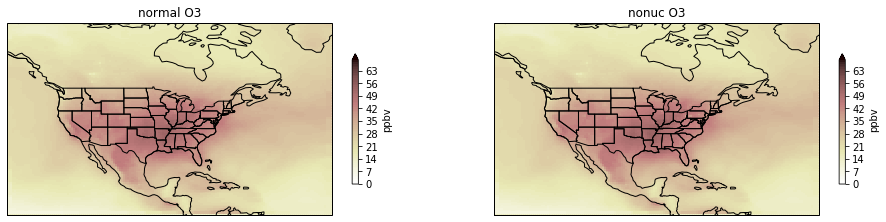

In [5]:
gridmod.concentration_plot(ds = ds, season = 'SON', species = 'O3', model_names = model_names, cmap = cmap_conc,
                       rows = 1, columns = 2, levels = levels_dict['O3'], lat_lon = lat_lon_dict['US_lat_lon'],
                       figsize = [16,8])

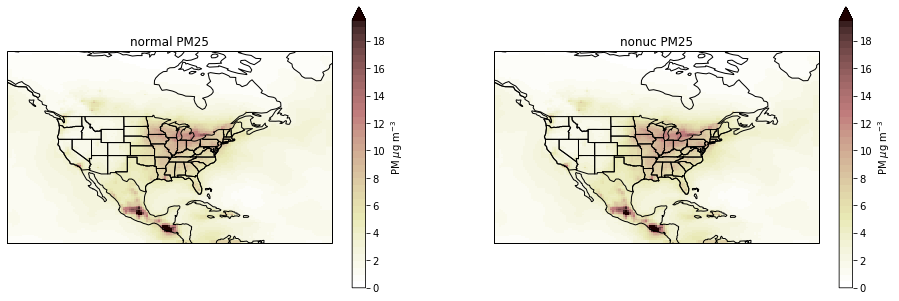

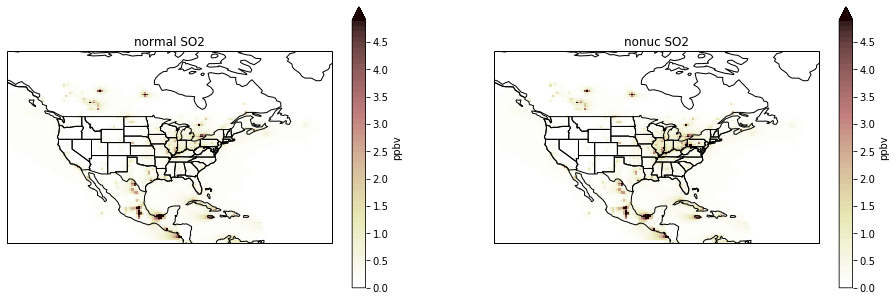

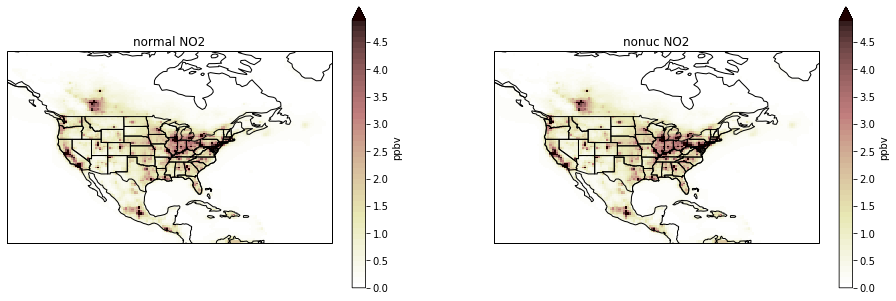

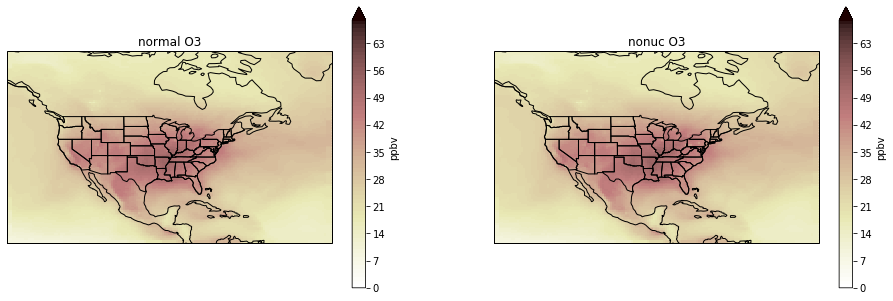

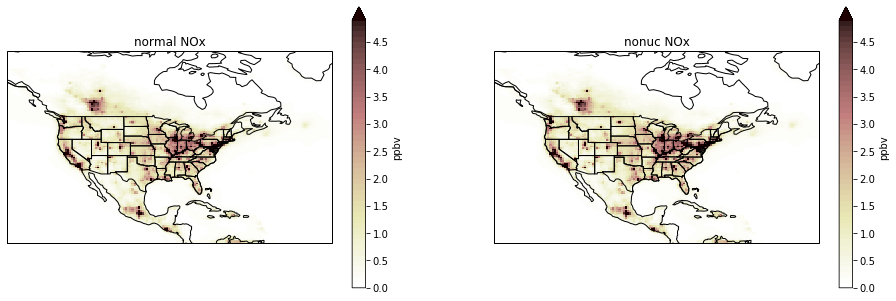

In [101]:
for species in list(species_dict.keys()):
    gridmod.concentration_plot(ds = ds, season = 'SON', species = species, model_names = model_names,  cmap = cmap_conc,
                       rows = 5, columns = 2, levels = levels_dict[species], lat_lon = lat_lon_dict['US_lat_lon'], shrink_cbar = .5,
                       figsize = [16,60])

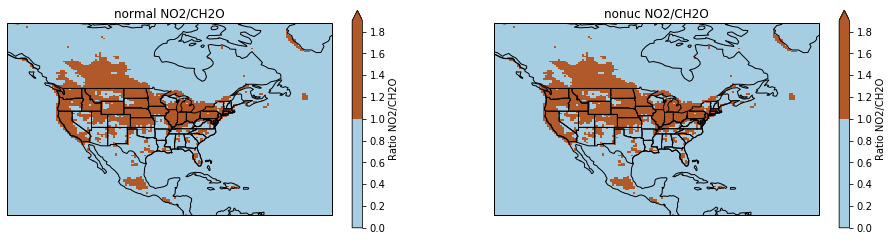

In [129]:
gridmod.concentration_plot(ds = ds, season = 'SON', species = 'NO2/CH2O', model_names = model_names, cmap = cmap_discrete,
                       rows = 1, columns = 2, levels = np.arange(0,2,.1), lat_lon = lat_lon_dict['US_lat_lon'], shrink_cbar = .5,
                       figsize = [16,8])

## Northeast

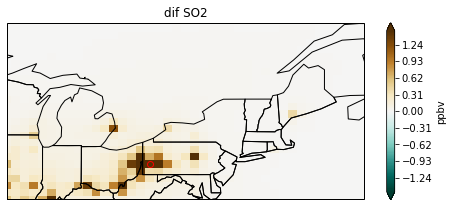

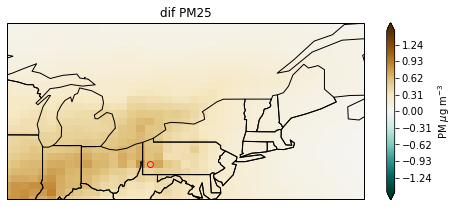

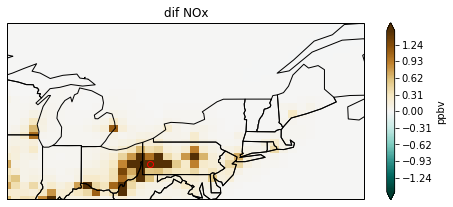

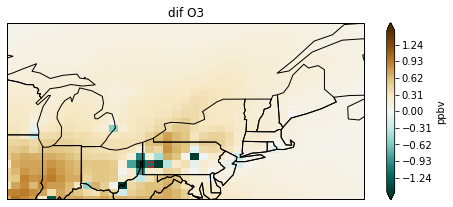

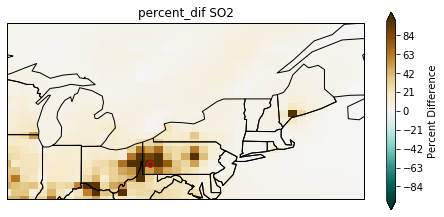

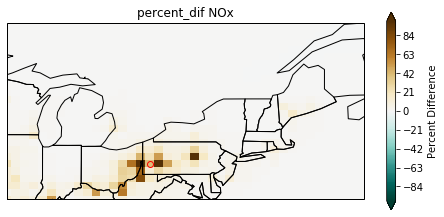

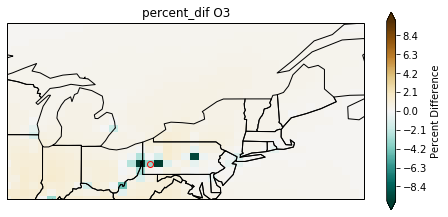

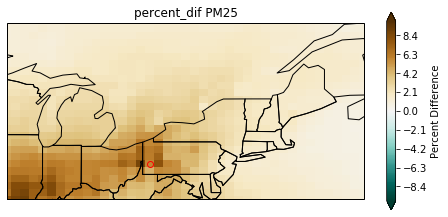

In [80]:
region = 'NE_lat_lon'
season = 'SON'

# plot the difference in NE of each species
for species in ['SO2','PM25','NOx','O3']:
    gridmod.concentration_plot(ds = ds, season = season, species = species, model_names = ['dif'],  cmap = cmap_dif, shrink_cbar = .5,
                           extension = 'both', rows = 4, columns = 1, figsize = [8,30], 
                           levels = levels_dict['regional_dif'], lat_lon = lat_lon_dict[region])
    plt.plot(cities_dict['Pittsburgh'][1],cities_dict['Pittsburgh'][0], marker = 'o',mfc = 'none', mec = 'r')            
# plot the difference in NE of each species
for species in ['SO2','NOx']:
    gridmod.concentration_plot(ds = ds, season = season, species = species, model_names = ['percent_dif'],  cmap = cmap_dif, shrink_cbar = .5,
                           extension = 'both', rows = 2, columns = 1, figsize = [8,16], 
                           levels = levels_dict['percent_dif_full'], lat_lon = lat_lon_dict[region])
    plt.plot(cities_dict['Pittsburgh'][1],cities_dict['Pittsburgh'][0], marker = 'o',mfc = 'none', mec = 'r')        
# plot the difference in NE of each species
for species in ['O3','PM25']:
    gridmod.concentration_plot(ds = ds, season = season, species = species, model_names = ['percent_dif'],  cmap = cmap_dif, shrink_cbar = .5,
                       extension = 'both', rows = 2, columns = 1, figsize = [8,16], 
                       levels = levels_dict['percent_dif_tight'], lat_lon = lat_lon_dict[region])
    plt.plot(cities_dict['Pittsburgh'][1],cities_dict['Pittsburgh'][0], marker = 'o',mfc = 'none', mec = 'r')

## Northwest

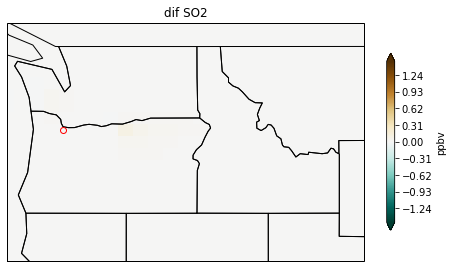

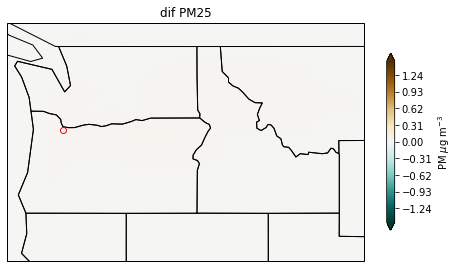

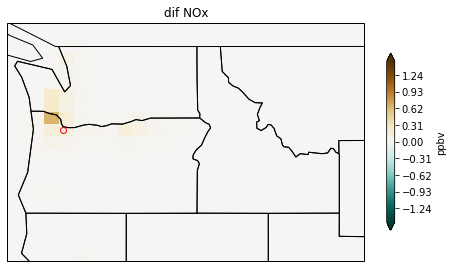

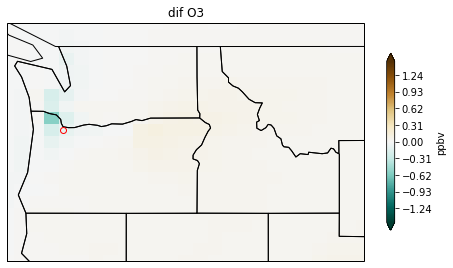

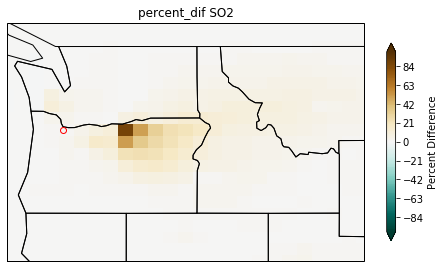

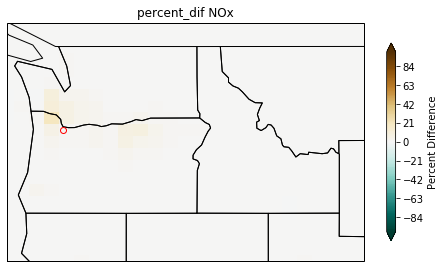

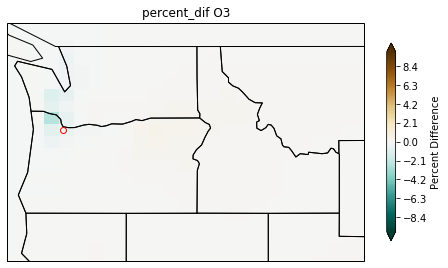

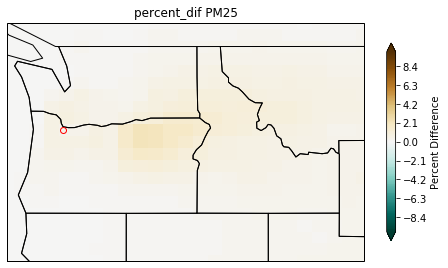

In [98]:
region = 'NW_lat_lon'
season = 'SON'

# plot the difference in NE of each species
for species in ['SO2','PM25','NOx','O3']:
    gridmod.concentration_plot(ds = ds, season = season, species = species, model_names = ['dif'],  cmap = cmap_dif, shrink_cbar = .5,
                           extension = 'both', rows = 4, columns = 1, figsize = [8,30], 
                           levels = levels_dict['regional_dif'], lat_lon = lat_lon_dict[region])
    plt.plot(cities_dict['Portland'][1],cities_dict['Portland'][0], marker = 'o',mfc = 'none', mec = 'r')            
# plot the difference in NE of each species
for species in ['SO2','NOx']:
    gridmod.concentration_plot(ds = ds, season = season, species = species, model_names = ['percent_dif'],  cmap = cmap_dif, shrink_cbar = .5,
                           extension = 'both', rows = 2, columns = 1, figsize = [8,16], 
                           levels = levels_dict['percent_dif_full'], lat_lon = lat_lon_dict[region])
    plt.plot(cities_dict['Portland'][1],cities_dict['Portland'][0], marker = 'o',mfc = 'none', mec = 'r')        
# plot the difference in NE of each species
for species in ['O3','PM25']:
    gridmod.concentration_plot(ds = ds, season = season, species = species, model_names = ['percent_dif'],  cmap = cmap_dif, shrink_cbar = .5,
                       extension = 'both', rows = 2, columns = 1, figsize = [8,16], 
                       levels = levels_dict['percent_dif_tight'], lat_lon = lat_lon_dict[region])
    plt.plot(cities_dict['Portland'][1],cities_dict['Portland'][0], marker = 'o',mfc = 'none', mec = 'r')

## Southwest

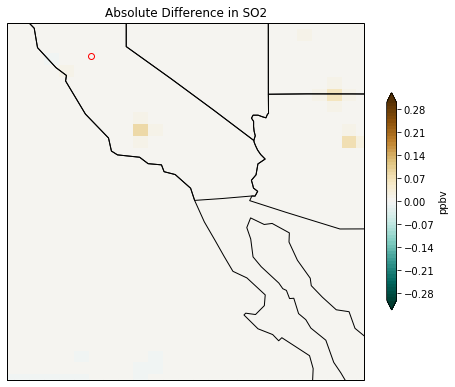

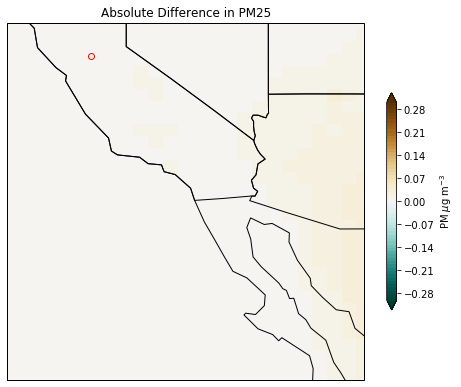

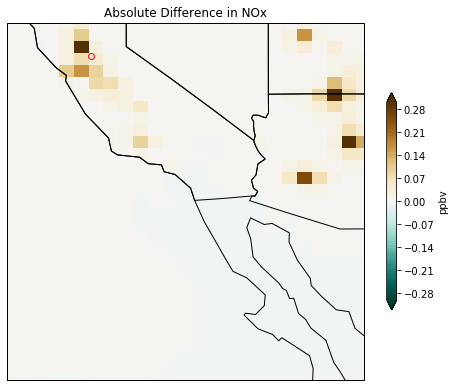

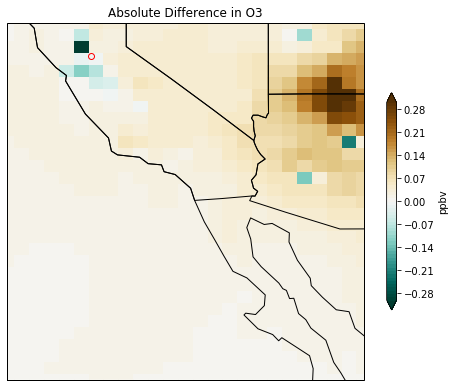

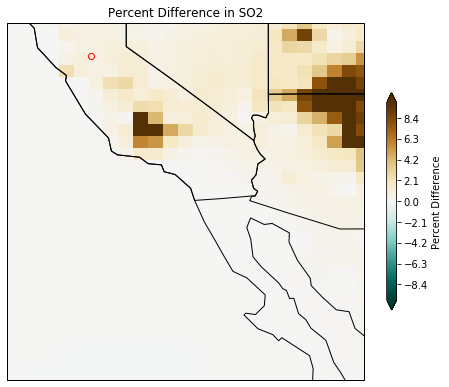

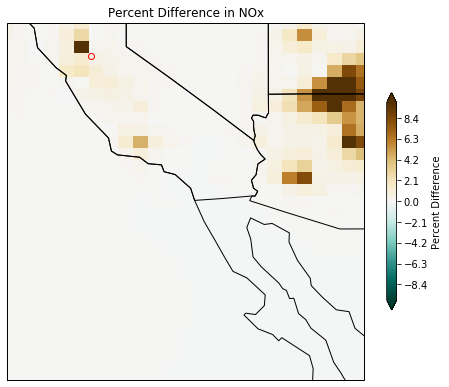

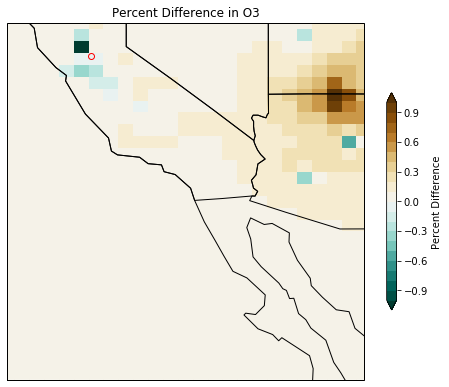

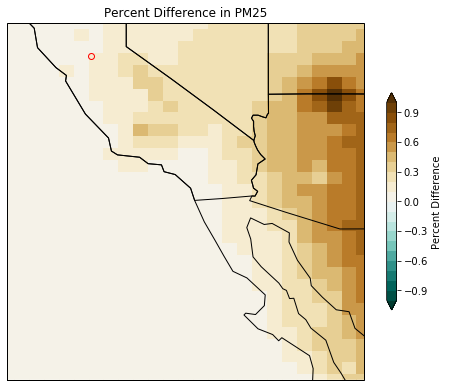

In [82]:
region = 'SW_lat_lon'
season = 'SON'

# plot the difference in NE of each species
for species in ['SO2','PM25','NOx','O3']:
    gridmod.concentration_plot(ds = ds, season = season, species = species, model_names = ['dif'],  cmap = cmap_dif, shrink_cbar = .5,
                       extension = 'both', rows = 1, columns = 1, figsize = [8,8], 
                       levels = levels_dict['regional_dif_tight'], lat_lon = lat_lon_dict[region])
    plt.title(f'Absolute Difference in {species}')
    plt.plot(cities_dict['Sacramento'][1],cities_dict['Sacramento'][0], marker = 'o',mfc = 'none', mec = 'r')
# plot the difference in NE of each species
for species in ['SO2','NOx']:
    gridmod.concentration_plot(ds = ds, season = season, species = species, model_names = ['percent_dif'],  cmap = cmap_dif, shrink_cbar = .5,
                       extension = 'both', rows = 1, columns = 1, figsize = [8,8], 
                       levels = levels_dict['percent_dif_tight'], lat_lon = lat_lon_dict[region])
    plt.title(f'Percent Difference in {species}')
    plt.plot(cities_dict['Sacramento'][1],cities_dict['Sacramento'][0], marker = 'o',mfc = 'none', mec = 'r')
# plot the difference in NE of each species
for species in ['O3','PM25']:
    gridmod.concentration_plot(ds = ds, season = season, species = species, model_names = ['percent_dif'],  cmap = cmap_dif, shrink_cbar = .5,
                       extension = 'both', rows = 1, columns = 1, figsize = [8,8], 
                       levels = np.arange(-1,1.1,.1), lat_lon = lat_lon_dict[region])
    plt.title(f'Percent Difference in {species}')
    plt.plot(cities_dict['Sacramento'][1],cities_dict['Sacramento'][0], marker = 'o',mfc = 'none', mec = 'r')

## Southeast

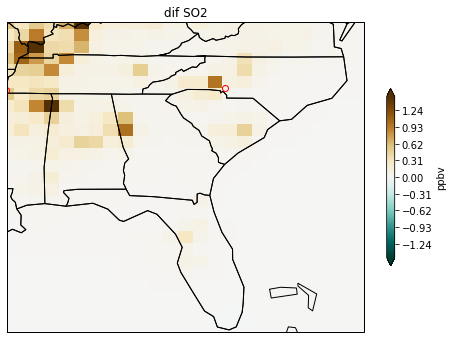

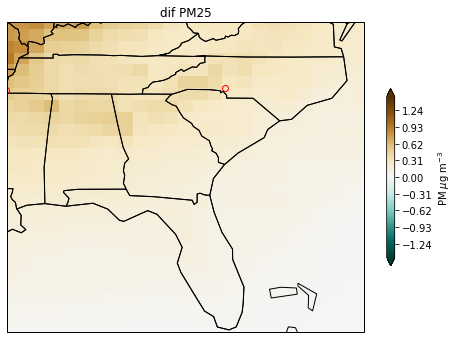

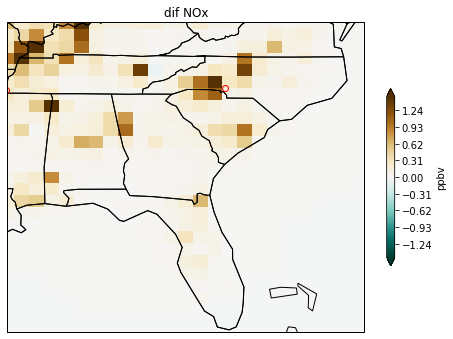

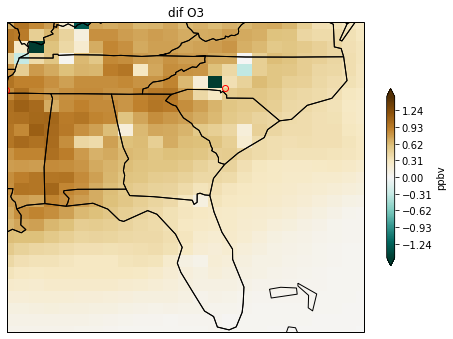

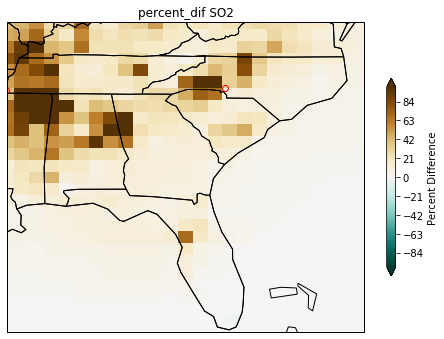

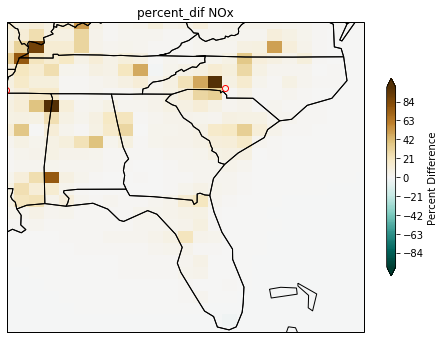

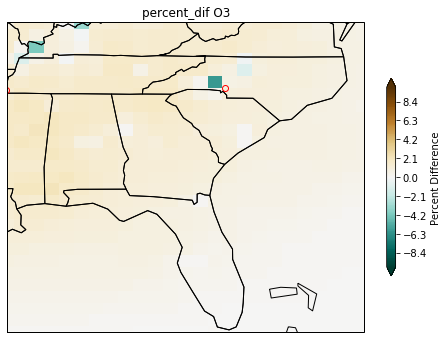

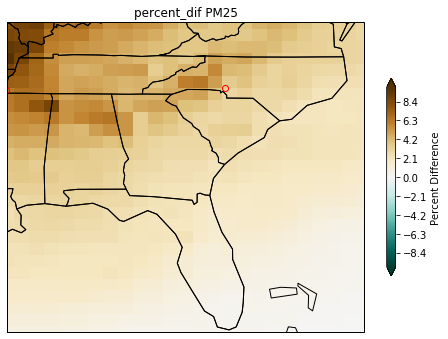

In [99]:
region = 'SE_lat_lon'
season = 'SON'

# plot the difference in NE of each species
for species in ['SO2','PM25','NOx','O3']:
    gridmod.concentration_plot(ds = ds, season = season, species = species, model_names = ['dif'],  cmap = cmap_dif, shrink_cbar = .5,
                       extension = 'both', rows = 4, columns = 1, figsize = [8,30], 
                       levels = levels_dict['regional_dif'], lat_lon = lat_lon_dict[region])
    plt.plot(cities_dict['Charlotte'][1],cities_dict['Charlotte'][0], marker = 'o',mfc = 'none', mec = 'r')
    plt.plot(cities_dict['Memphis'][1],cities_dict['Memphis'][0], marker = 'o',mfc = 'none', mec = 'r')
# plot the difference in NE of each species
for species in ['SO2','NOx']:
    gridmod.concentration_plot(ds = ds, season = season, species = species, model_names = ['percent_dif'],  cmap = cmap_dif, shrink_cbar = .5,
                       extension = 'both', rows = 2, columns = 1, figsize = [8,16], 
                       levels = levels_dict['percent_dif_full'], lat_lon = lat_lon_dict[region])
    plt.plot(cities_dict['Charlotte'][1],cities_dict['Charlotte'][0], marker = 'o',mfc = 'none', mec = 'r')
    plt.plot(cities_dict['Memphis'][1],cities_dict['Memphis'][0], marker = 'o',mfc = 'none', mec = 'r')
# plot the difference in NE of each species
for species in ['O3','PM25']:
    gridmod.concentration_plot(ds = ds, season = season, species = species, model_names = ['percent_dif'],  cmap = cmap_dif, shrink_cbar = .5,
                       extension = 'both', rows = 2, columns = 1, figsize = [8,16], 
                       levels = levels_dict['percent_dif_tight'], lat_lon = lat_lon_dict[region])
    plt.plot(cities_dict['Charlotte'][1],cities_dict['Charlotte'][0], marker = 'o',mfc = 'none', mec = 'r')
    plt.plot(cities_dict['Memphis'][1],cities_dict['Memphis'][0], marker = 'o',mfc = 'none', mec = 'r')

## Midwest

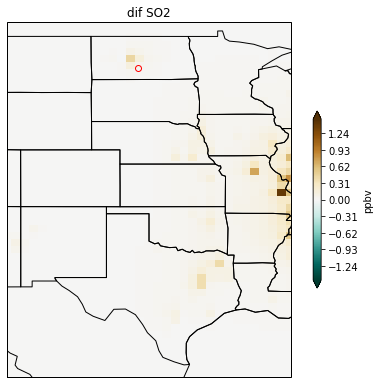

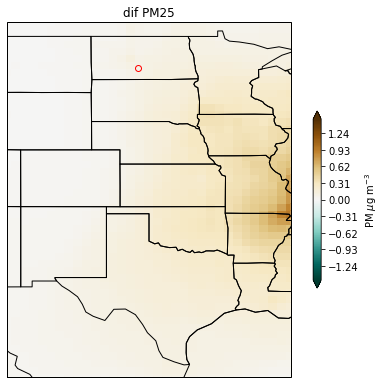

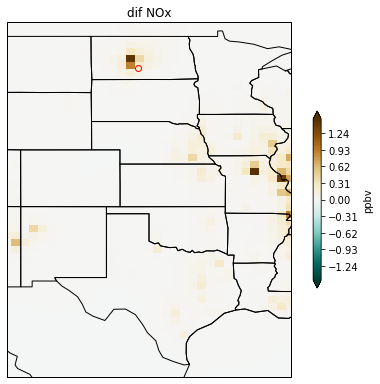

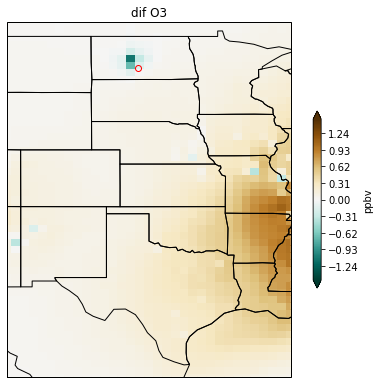

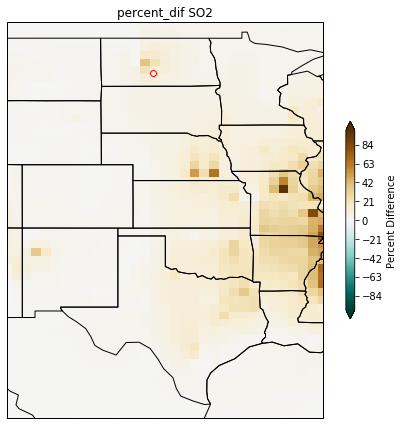

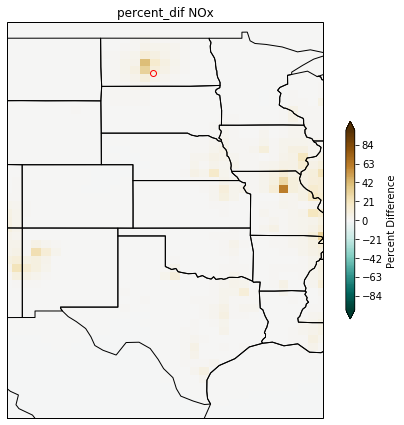

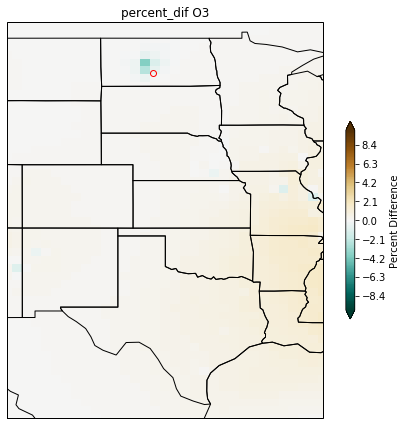

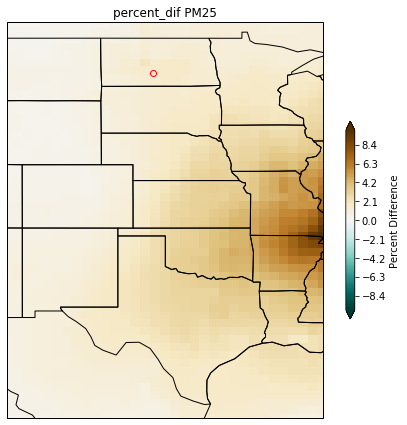

In [96]:
region = 'MW_lat_lon'
season = 'SON'

# plot the difference in NE of each species
for species in ['SO2','PM25','NOx','O3']:
    gridmod.concentration_plot(ds = ds, season = season, species = species, model_names = ['dif'],  cmap = cmap_dif, shrink_cbar = .5,
                       extension = 'both', rows = 4, columns = 1, figsize = [8,30], 
                       levels = levels_dict['regional_dif'], lat_lon = lat_lon_dict[region])
    plt.plot(cities_dict['Bismarck'][1],cities_dict['Bismarck'][0], marker = 'o',mfc = 'none', mec = 'r')
# plot the difference in NE of each species
for species in ['SO2','NOx']:
    gridmod.concentration_plot(ds = ds, season = season, species = species, model_names = ['percent_dif'],  cmap = cmap_dif, shrink_cbar = .5,
                       extension = 'both', rows = 2, columns = 1, figsize = [8,16], 
                       levels = levels_dict['percent_dif_full'], lat_lon = lat_lon_dict[region])
    plt.plot(cities_dict['Bismarck'][1],cities_dict['Bismarck'][0], marker = 'o',mfc = 'none', mec = 'r')
# plot the difference in NE of each species
for species in ['O3','PM25']:
    gridmod.concentration_plot(ds = ds, season = season, species = species, model_names = ['percent_dif'],  cmap = cmap_dif, shrink_cbar = .5,
                       extension = 'both', rows = 2, columns = 1, figsize = [8,16], 
                       levels = levels_dict['percent_dif_tight'], lat_lon = lat_lon_dict[region])
    plt.plot(cities_dict['Bismarck'][1],cities_dict['Bismarck'][0], marker = 'o',mfc = 'none', mec = 'r')

In [10]:
print('max difference in PM '+ str(ds['dif_PM25'].max().values) + ' and min ' + str(ds['dif_PM25'].min().values))
print('max difference in O3 '+ str(ds['dif_O3'].max().values) + ' and min ' + str(ds['dif_O3'].min().values))


max difference in PM 3.91041 and min -0.38135338
max difference in O3 8.998234 and min -14.410147


In [ ]:
fig = plt.figure(figsize=[24,12])

for idx, s in enumerate(species_names): 
    ax = fig.add_subplot(3,4,idx+1)
    plt.subplots_adjust(hspace = .6)
    plt.plot(ds['time'],ds[f'{s}'].mean(dim=['lat','lon']),'o');
    plt.xlabel('Date')
    plt.ylabel(f'{s} Concentration');
    plt.xticks(rotation=45)
    plt.title(f'{s}')

In [ ]:
plt.plot(ds['time'],ds[f'NEI_NOx'].mean(dim=['lat','lon']),'ro')
spl = UnivariateSpline(Xnew,ds[f'NEI_NOx'].mean(dim=['lat','lon']), s = 0.1)
xs = np.linspace(Xnew.min(), Xnew.max(), 1000)
plt.plot(xs, spl(xs), 'g', lw=3)

In [ ]:
Xnew = matplotlib.dates.date2num(ds['time'])
